In [1]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


2024-11-12 17:23:36.085763: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 17:23:36.088928: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 17:23:36.098316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 17:23:36.123596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 17:23:36.131476: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 17:23:36.148658: I tensorflow/core/platform/cpu_feature_gu

### Import Data

In [2]:
import pandas as pd

spring_df = pd.read_csv('/workspaces/time-series-project-tutorial/acea-water-prediction/Water_Spring_Amiata.csv')
spring_df.head()

,Date,Rainfall_Castel_del_Piano,Rainfall_Abbadia_S_Salvatore,Rainfall_S_Fiora,Rainfall_Laghetto_Verde,Rainfall_Vetta_Amiata,Depth_to_Groundwater_S_Fiora_8,Depth_to_Groundwater_S_Fiora_11bis,Depth_to_Groundwater_David_Lazzaretti,Temperature_Abbadia_S_Salvatore,Temperature_S_Fiora,Temperature_Laghetto_Verde,Flow_Rate_Bugnano,Flow_Rate_Arbure,Flow_Rate_Ermicciolo,Flow_Rate_Galleria_Alta
0,01/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.15,NaN,NaN,NaN,NaN,NaN
1,02/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.55,NaN,NaN,NaN,NaN,NaN
2,03/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.70,NaN,NaN,NaN,NaN,NaN
3,04/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,NaN,NaN
4,05/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.60,NaN,NaN,NaN,NaN,NaN


In [3]:
spring_df.isnull().sum()
spring_df = spring_df.dropna()
print(spring_df)

            Date  Rainfall_Castel_del_Piano  Rainfall_Abbadia_S_Salvatore  \
5869  26/01/2016                        0.0                           0.0   
5870  27/01/2016                        0.0                           0.0   
5871  28/01/2016                        0.0                           0.0   
5872  29/01/2016                        0.0                           0.0   
5873  30/01/2016                        0.0                           0.0   
...          ...                        ...                           ...   
7482  26/06/2020                        0.0                           0.0   
7483  27/06/2020                        0.0                           0.0   
7484  28/06/2020                        0.0                           0.0   
7485  29/06/2020                        0.0                           0.0   
7486  30/06/2020                        0.0                           0.0   

      Rainfall_S_Fiora  Rainfall_Laghetto_Verde  Rainfall_Vetta_Amiata  \
5

### Format Time Series Date Field

In [4]:
from datetime import datetime

original_date = spring_df['Date']
parsed_date = original_date.apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))

# Format to mm/dd/yyyy
spring_df['formatted_date'] = pd.to_datetime(spring_df['Date'], format="%d/%m/%Y").dt.strftime("%m/%d/%Y")

print(spring_df['formatted_date'])


5869    01/26/2016
5870    01/27/2016
5871    01/28/2016
5872    01/29/2016
5873    01/30/2016
           ...    
7482    06/26/2020
7483    06/27/2020
7484    06/28/2020
7485    06/29/2020
7486    06/30/2020
Name: formatted_date, Length: 923, dtype: object


In [5]:
spring_df = spring_df.set_index('formatted_date')
spring_df = spring_df.drop(columns=['Date'])
spring_df.head()

,Rainfall_Castel_del_Piano,Rainfall_Abbadia_S_Salvatore,Rainfall_S_Fiora,Rainfall_Laghetto_Verde,Rainfall_Vetta_Amiata,Depth_to_Groundwater_S_Fiora_8,Depth_to_Groundwater_S_Fiora_11bis,Depth_to_Groundwater_David_Lazzaretti,Temperature_Abbadia_S_Salvatore,Temperature_S_Fiora,Temperature_Laghetto_Verde,Flow_Rate_Bugnano,Flow_Rate_Arbure,Flow_Rate_Ermicciolo,Flow_Rate_Galleria_Alta
formatted_date,,,,,,,,,,,,,,,
01/26/2016,0.0,0.0,0.0,0.0,0.0,-36.87,-50.73,-294.94,7.05,7.60,4.65,-0.327773,-2.872341,-5.035054,-21.504943
01/27/2016,0.0,0.0,0.2,0.0,0.0,-36.87,-50.74,-294.98,7.55,8.10,6.70,-0.327773,-2.872341,-5.035054,-21.504943
01/28/2016,0.0,0.0,0.0,0.0,0.0,-36.88,-50.74,-295.02,6.85,5.80,5.55,-0.327773,-2.872341,-5.035054,-21.504943
01/29/2016,0.0,0.0,0.0,0.0,0.0,-36.88,-50.74,-295.06,6.75,7.80,5.05,-0.327773,-2.872341,-5.035054,-21.504943
01/30/2016,0.0,0.0,0.0,0.0,0.0,-36.89,-50.75,-295.09,6.35,5.95,4.60,-0.327773,-2.872341,-5.035054,-21.504943


In [6]:
spring_df.columns

Index(['Rainfall_Castel_del_Piano', 'Rainfall_Abbadia_S_Salvatore',
       'Rainfall_S_Fiora', 'Rainfall_Laghetto_Verde', 'Rainfall_Vetta_Amiata',
       'Depth_to_Groundwater_S_Fiora_8', 'Depth_to_Groundwater_S_Fiora_11bis',
       'Depth_to_Groundwater_David_Lazzaretti',
       'Temperature_Abbadia_S_Salvatore', 'Temperature_S_Fiora',
       'Temperature_Laghetto_Verde', 'Flow_Rate_Bugnano', 'Flow_Rate_Arbure',
       'Flow_Rate_Ermicciolo', 'Flow_Rate_Galleria_Alta'],
      dtype='object')

## Multivariate Analysis - LSTM 

### Min Max Scaling

#### Function to Min Max scale multiple features

In [7]:
target_columns = spring_df[['Flow_Rate_Bugnano', 'Flow_Rate_Arbure', 'Flow_Rate_Ermicciolo', 'Flow_Rate_Galleria_Alta']].columns.tolist()
feature_columns = spring_df.drop(columns=target_columns).columns.tolist()

#target_columns.dtypes

In [8]:
# Ensure X is defined

def prepare_multi_feature_data(df, feature_columns, target_columns, lookback=30):
    """
    Prepare multi-feature sequences for LSTM model
    """
    
    X, y = [], []
    # Scale the features
    scaler_features = MinMaxScaler()
    scaled_features = scaler_features.fit_transform(df[feature_columns])
    
    # Scale the target separately
    scaler_target = MinMaxScaler()
    scaled_target = scaler_target.fit_transform(df[target_columns])
    
    for i in range(len(df) - lookback):
        # Features: take all feature columns for the lookback period
        X.append(scaled_features[i:(i + lookback)])
        # Targets: take all target columns for the prediction point
        y.append(scaled_target[(i + lookback)])
    
    return X, y, scaler_features, scaler_target

# Call the function with debugging
try:
    X, y, scaler_features, scaler_target = prepare_multi_feature_data(spring_df, feature_columns, target_columns, lookback=30)
    print(scaler_target)
except ValueError as e:
    print("ValueError encountered:", e)
    # print("spring_df shape:", spring_df.shape)
    # print("feature_columns:", feature_columns)
    # print("target_columns:", target_columns)
    # print("lookback:", 7)





MinMaxScaler()


#### Define Test Train Split Myself <br>

In [9]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
test_size = len(X) - train_size
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
#print(y_train)


Train size: 714, Test size: 179


### LSTM Model Multi-Target

In [10]:
from tensorflow.keras.layers import Bidirectional

n_features = len(feature_columns)

model = Sequential([
    # Increase capacity for better pattern recognition
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(30, n_features))),
    Dropout(0.3),
    
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dense(4)
])

# Use Huber loss to handle outliers better
model.compile(optimizer=Adam(learning_rate=0.0005), loss='huber')

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
import numpy as np

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

# Ensure the shapes are compatible
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,#increase to 64 
    validation_split=0.1,
    verbose=1
)

X_train shape: (714, 30, 11)
y_train shape: (714, 4)
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - loss: 0.0493 - val_loss: 0.0134
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0296 - val_loss: 0.0090
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0252 - val_loss: 0.0126
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0244 - val_loss: 0.0118
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0206 - val_loss: 0.0172
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0217 - val_loss: 0.0168
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0206 - val_loss: 0.0166
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0202 - val_loss: 0.0174
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0218 - val_loss: 0.0133
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0183 - val_loss: 0.0148
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0184 - val_loss: 0.0092
Ep

### Model Predictions
We train the model on the train data and the test data to see how well <br>
we are predicting the training and testing data

In [12]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print(test_pred)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0.27231652 0.2789319  0.43344468 0.67635643]
 [0.2588733  0.25659555 0.3955643  0.68310577]
 [0.25992665 0.2564407  0.39871716 0.69096875]
 [0.25517458 0.24872762 0.38547215 0.69534373]
 [0.25302985 0.24484462 0.37903365 0.6978584 ]
 [0.25030544 0.24738659 0.39243367 0.6849326 ]
 [0.24655285 0.24620843 0.40028325 0.6793955 ]
 [0.24121404 0.239892   0.40058985 0.67669904]
 [0.23233739 0.22827986 0.38937935 0.6724168 ]
 [0.2316775  0.22837456 0.39084423 0.66356826]
 [0.23074356 0.22673981 0.38952592 0.65600896]
 [0.22909623 0.22284363 0.38917965 0.65278184]
 [0.22416937 0.21429496 0.37937412 0.64858466]
 [0.22271636 0.2108136  0.37626383 0.6437684 ]
 [0.22336367 0.21051784 0.37874886 0.6401122 ]
 [0.22472814 0.21139543 0.38181278 0.63663375]
 [0.22308427 0.20820008 0.3722889  0.6307595 ]
 [0.22439349 0.21038412 0.37317857 0.6261855 ]
 [0.22931135 0.21743095 0.38469392 0.62275445]
 [0.23141402 0.219673   0.388

### Convert back to normal scale

In [13]:
# Inverse transform predictions
train_pred = scaler_target.inverse_transform(train_pred)
test_pred = scaler_target.inverse_transform(test_pred)
y_train_orig = scaler_target.inverse_transform(y_train)
y_test_orig = scaler_target.inverse_transform(y_test)



### Evaluate Loss

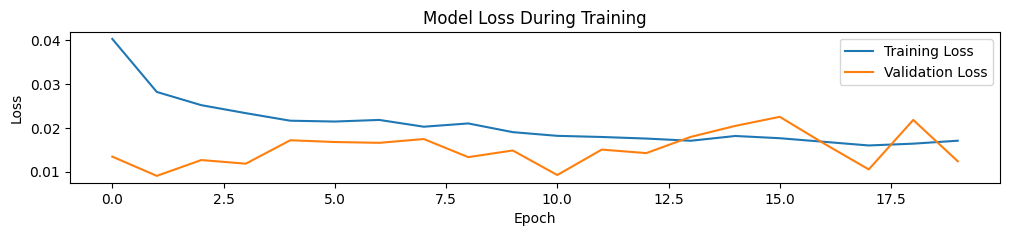

In [14]:
import matplotlib.pyplot as plt


# Create visualizations
plt.figure(figsize=(12, 9))

# Plot 1: Training Loss
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Evaluate Progress

In [15]:
def evaluate_regression_lstm(y_true, y_pred):
    # R² score (1.0 is perfect prediction)
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)
    
    # Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Custom accuracy metric for regression (as percentage)
    # Using 1 - normalized MAE as a proxy for accuracy
    #accuracy = (1 - mae / (y_true.max() - y_true.min())) * 100
    
    print("\nRegression Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    #print(f"Accuracy (based on normalized MAE): {accuracy:.2f}%")
    
    return r2, mae, rmse

### Evaluate 3 Targets

In [17]:
evaluate_regression_lstm(y_test_orig[0], test_pred[0])


Regression Metrics:
R² Score: 0.9970
MAE: 0.3356
RMSE: 0.4203


(0.9969704088853751, 0.33559283411276614, 0.4202545739874303)

In [18]:
evaluate_regression_lstm(y_test_orig[1], test_pred[1])


Regression Metrics:
R² Score: 0.9956
MAE: 0.3632
RMSE: 0.5050


(0.995625395581632, 0.3632079044557837, 0.5049982037584869)

In [19]:
evaluate_regression_lstm(y_test_orig[2], test_pred[2])


Regression Metrics:
R² Score: 0.9958
MAE: 0.3435
RMSE: 0.4945


(0.9958048424678413, 0.3434988687015799, 0.49453220217096905)

## Find Optimal Learning Rate 

In [20]:
# def find_optimal_lr(model, X_train, y_train):
#     lr_schedule = np.logspace(-4, -2, 100)  # Test from 0.0001 to 0.01
#     losses = []
    
#     for lr in lr_schedule:
#         model.optimizer.learning_rate.assign(lr)
#         loss = model.train_on_batch(X_train[:32], y_train[:32])
#         losses.append(loss)
        
#     best_lr = lr_schedule[np.argmin(losses)]
#     return best_lr

# find_optimal_lr(model, X_train, y_train)

## Plot Residuals - Actual vs Predicted

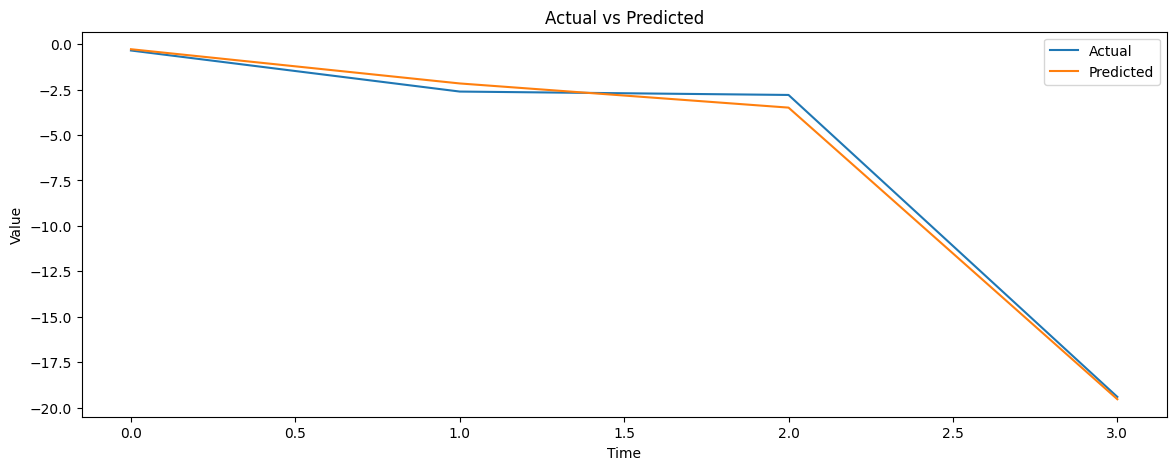

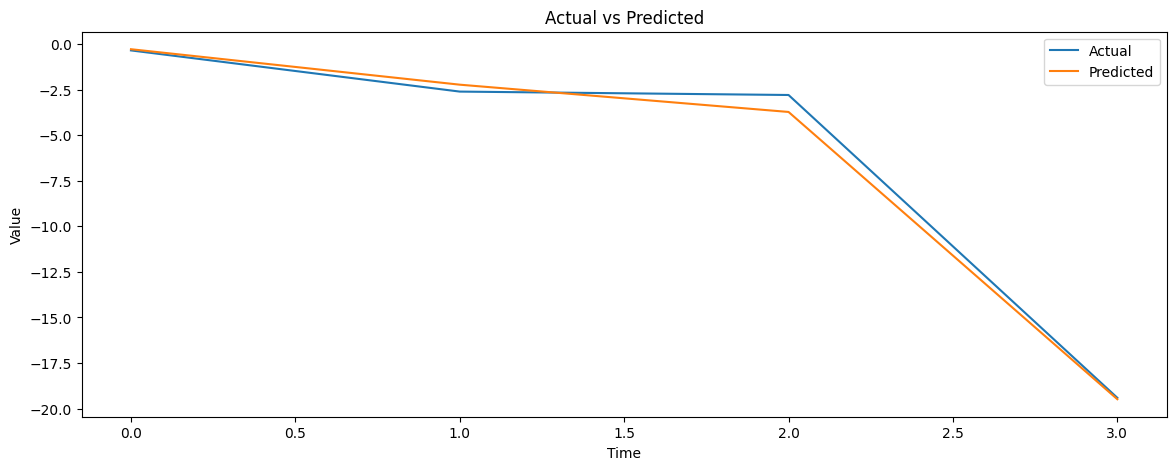

In [21]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted'):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Assuming y_test and test_pred are defined
plot_actual_vs_predicted(y_test_orig[0], test_pred[0])
plot_actual_vs_predicted(y_test_orig[1], test_pred[1])

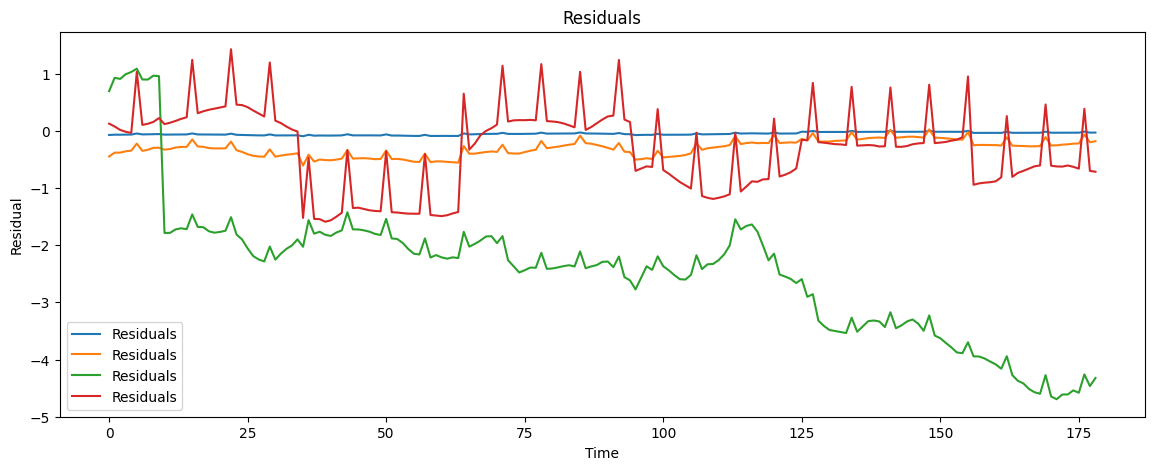

In [22]:
def plot_residuals(y_true, y_pred, title='Residuals'):
    residuals = y_true - y_pred
    plt.figure(figsize=(14, 5))
    plt.plot(residuals, label='Residuals')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()
    
    
plot_residuals(y_test_orig, test_pred, title='Residuals')